In [1]:
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import namedtuple
from scipy.integrate import ode, solve_ivp

In [2]:
# better graphs
sns.set()

# instantiate logger
logger = logging.getLogger(__name__)

# `ode` interface

In [3]:
PATIENT_PARA_FILE = "./patient_params.csv"

In [4]:
Action = namedtuple("patient_action", ['CHO', 'insulin'])
Observation = namedtuple("observation", ['Gsub'])

class Sim:
    SAMPLE_TIME = 1
    EAT_RATE = 5

    def __init__(self, params, init_state=None, random_init_bg=False, seed=None, t0=0):
        self._params = params
        self._init_state = init_state
        self.random_init_bg = random_init_bg
        self._seed = seed
        self.t0 = t0

        self.reset()

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed
        self.reset()

    def reset(self):
        '''
        Reset the patient state to default intial state
        '''
        if self._init_state is None:
            self.init_state = self._params.iloc[2:15]
        else:
            self.init_state = self._init_state

        self.random_state = np.random.RandomState(self.seed)
        if self.random_init_bg:
            # Only randomize glucose related states, x4, x5, and x13
            mean = [
                1.0 * self.init_state[3], 1.0 * self.init_state[4],
                1.0 * self.init_state[12]
            ]
            cov = np.diag([
                0.1 * self.init_state[3], 0.1 * self.init_state[4],
                0.1 * self.init_state[12]
            ])
            bg_init = self.random_state.multivariate_normal(mean, cov)
            self.init_state[3] = 1.0 * bg_init[0]
            self.init_state[4] = 1.0 * bg_init[1]
            self.init_state[12] = 1.0 * bg_init[2]

        self._last_Qsto = self.init_state[0] + self.init_state[1]
        self._last_foodtaken = 0
        self.name = self._params.Name

        self._odesolver = ode(self.model).set_integrator('dopri5')
        self._odesolver.set_initial_value(self.init_state, self.t0)

        self._last_action = Action(CHO=0, insulin=0)
        self.is_eating = False
        self.planned_meal = 0

    @classmethod
    def withName(cls, name, **kwargs):
        '''
        Construct patient by name.
        Names can be
            adolescent#001 - adolescent#010
            adult#001 - adult#001
            child#001 - child#010
        '''
        patient_params = pd.read_csv(PATIENT_PARA_FILE)
        params = patient_params.loc[patient_params.Name == name].squeeze()
        return cls(params, **kwargs)

    @property
    def state(self):
        return self._odesolver.y

    @property
    def t(self):
        return self._odesolver.t

    @property
    def sample_time(self):
        return self.SAMPLE_TIME

    @property
    def observation(self):
        '''
        return the observation from patient
        for now, only the subcutaneous glucose level is returned
        TODO: add heart rate as an observation
        '''
        GM = self.state[12]  # subcutaneous glucose (mg/kg)
        Gsub = GM / self._params.Vg
        observation = Observation(Gsub=Gsub)
        return observation

    def step(self, action):
        # Convert announcing meal to the meal amount to eat at the moment
        to_eat = self._announce_meal(action.CHO)
        action = action._replace(CHO=to_eat)

        # Detect eating or not and update last digestion amount
        if action.CHO > 0 and self._last_action.CHO <= 0:
            logger.info('t = {}, patient starts eating ...'.format(self.t))
            self._last_Qsto = self.state[0] + self.state[1]  # unit: mg
            self._last_foodtaken = 0  # unit: g
            self.is_eating = True

        if to_eat > 0:
            logger.debug('t = {}, patient eats {} g'.format(
                self.t, action.CHO))

        if self.is_eating:
            self._last_foodtaken += action.CHO  # g

        # Detect eating ended
        if action.CHO <= 0 and self._last_action.CHO > 0:
            logger.info('t = {}, Patient finishes eating!'.format(self.t))
            self.is_eating = False

        # Update last input
        self._last_action = action

        # ODE solver
        self._odesolver.set_f_params(action, self._params, self._last_Qsto,
                                     self._last_foodtaken)
        if self._odesolver.successful():
            self._odesolver.integrate(self._odesolver.t + self.sample_time)
        else:
            logger.error('ODE solver failed!!')
            raise

    @staticmethod
    def model(t, x, action, params, last_Qsto, last_foodtaken):
        dxdt = np.zeros(13)
        d = action.CHO * 1000  # g -> mg
        insulin = action.insulin * 6000 / params.BW  # U/min -> pmol/kg/min
        basal = params.u2ss * params.BW / 6000  # U/min

        # Glucose in the stomach
        qsto = x[0] + x[1]
        # NOTE: Dbar is in unit mg, hence last_foodtaken needs to be converted
        # from mg to g. See https://github.com/jxx123/simglucose/issues/41 for
        # details.
        Dbar = last_Qsto + last_foodtaken * 1000  # unit: mg

        # Stomach solid
        dxdt[0] = -params.kmax * x[0] + d

        if Dbar > 0:
            aa = 5 / 2 / (1 - params.b) / Dbar
            cc = 5 / 2 / params.d / Dbar
            kgut = params.kmin + (params.kmax - params.kmin) / 2 * (
                np.tanh(aa * (qsto - params.b * Dbar)) -
                np.tanh(cc * (qsto - params.d * Dbar)) + 2)
        else:
            kgut = params.kmax

        # stomach liquid
        dxdt[1] = params.kmax * x[0] - x[1] * kgut

        # intestine
        dxdt[2] = kgut * x[1] - params.kabs * x[2]

        # Rate of appearance
        Rat = params.f * params.kabs * x[2] / params.BW
        # Glucose Production
        EGPt = params.kp1 - params.kp2 * x[3] - params.kp3 * x[8]
        # Glucose Utilization
        Uiit = params.Fsnc

        # renal excretion
        if x[3] > params.ke2:
            Et = params.ke1 * (x[3] - params.ke2)
        else:
            Et = 0

        # glucose kinetics
        # plus dextrose IV injection input u[2] if needed
        dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - \
            params.k1 * x[3] + params.k2 * x[4]
        dxdt[3] = (x[3] >= 0) * dxdt[3]

        Vmt = params.Vm0 + params.Vmx * x[6]
        Kmt = params.Km0
        Uidt = Vmt * x[4] / (Kmt + x[4])
        dxdt[4] = -Uidt + params.k1 * x[3] - params.k2 * x[4]
        dxdt[4] = (x[4] >= 0) * dxdt[4]

        # insulin kinetics
        dxdt[5] = -(params.m2 + params.m4) * x[5] + params.m1 * x[9] + params.ka1 * \
            x[10] + params.ka2 * x[11]  # plus insulin IV injection u[3] if needed
        It = x[5] / params.Vi
        dxdt[5] = (x[5] >= 0) * dxdt[5]

        # insulin action on glucose utilization
        dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

        # insulin action on production
        dxdt[7] = -params.ki * (x[7] - It)

        dxdt[8] = -params.ki * (x[8] - x[7])

        # insulin in the liver (pmol/kg)
        dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
        dxdt[9] = (x[9] >= 0) * dxdt[9]

        # subcutaneous insulin kinetics
        dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
        dxdt[10] = (x[10] >= 0) * dxdt[10]

        dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
        dxdt[11] = (x[11] >= 0) * dxdt[11]

        # subcutaneous glucose
        dxdt[12] = (-params.ksc * x[12] + params.ksc * x[3])
        dxdt[12] = (x[12] >= 0) * dxdt[12]

        if action.insulin > basal:
            logger.debug('t = {}, injecting insulin: {}'.format(
                t, action.insulin))

        return dxdt

    @property
    def observation(self):
        '''
        return the observation from patient
        for now, only the subcutaneous glucose level is returned
        TODO: add heart rate as an observation
        '''
        GM = self.state[12]  # subcutaneous glucose (mg/kg)
        Gsub = GM / self._params.Vg
        observation = Observation(Gsub=Gsub)
        return observation

    def _announce_meal(self, meal):
        '''
        patient announces meal.
        The announced meal will be added to self.planned_meal
        The meal is consumed in self.EAT_RATE
        The function will return the amount to eat at current time
        '''
        self.planned_meal += meal
        if self.planned_meal > 0:
            to_eat = min(self.EAT_RATE, self.planned_meal)
            self.planned_meal -= to_eat
            self.planned_meal = max(0, self.planned_meal)
        else:
            to_eat = 0
        return to_eat

In [21]:
p = Sim.withName('adolescent#001')
basal = p._params.u2ss * p._params.BW / 6000  # U/min
t = []
CHO = []
insulin = []
BG = []
while p.t < 60 * 60:
    ins = basal
    carb = 0
    if p.t == 100:
        carb = 80
        ins = 80.0 / 6.0 + basal
    if p.t == 1000:
        carb = 100
        ins = 100.0 / 12.0 + basal
    act = Action(insulin=ins, CHO=carb)
    t.append(p.t)
    CHO.append(act.CHO)
    insulin.append(act.insulin)
    BG.append(p.observation.Gsub)
    p.step(act)

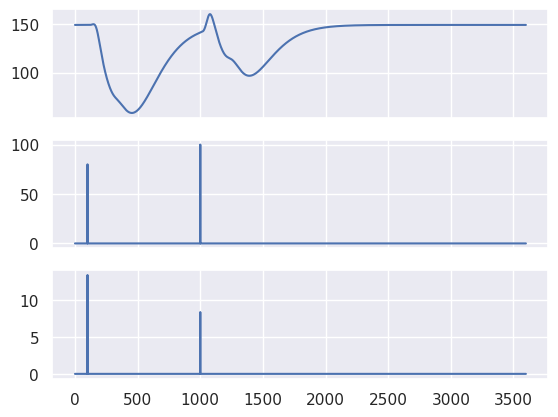

In [22]:
fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(t, BG)
ax[1].plot(t, CHO)
ax[2].plot(t, insulin)
plt.show()